## The objective of this notebook is to develop ML models with tunning parameters to predict the target variable.

In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
# importing grid search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# import our models
#Logistic Regression
from sklearn.linear_model import LogisticRegression
#linear SVC
from sklearn.svm import LinearSVC

#ensemble models
#random forest
from sklearn.ensemble import RandomForestClassifier
#gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

#importing the data scaling and pipeline libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
#importing test train split
from sklearn.model_selection import train_test_split


import os
#importing time to measure the time of execution
import time


plt.style.use("ggplot")

In [2]:
#%pip install xgboost

In [3]:
# Loading our data
data_base = pd.read_pickle('data_base.pkl')
data_base.head()

,date,home_team,away_team,season,home_win,home_rolling_fg,home_rolling_fga,home_rolling_fg%,home_rolling_3p,home_rolling_3pa,...,away_rolling_opponent_drb%_max,away_rolling_opponent_trb%_max,away_rolling_opponent_ast%_max,away_rolling_opponent_stl%_max,away_rolling_opponent_blk%_max,away_rolling_opponent_tov%_max,away_rolling_opponent_usg%_max,away_rolling_opponent_ortg_max,away_rolling_opponent_drtg_max,away_rolling_opponent_Total
0,2017-11-05 00:00:00.000000,CLE,ATL,2017-18,0,38.333333,85.833333,0.446833,9.166667,30.833333,...,39.733333,24.250000,40.600000,4.966667,9.466667,34.283333,27.466667,153.833333,104.666667,109.000000
1,2017-11-05 00:00:00.000000,NYK,IND,2017-18,1,41.666667,87.666667,0.476000,8.666667,27.333333,...,38.383333,26.300000,47.133333,5.516667,17.716667,30.066667,33.066667,178.000000,121.000000,111.500000
2,2017-11-07 00:00:00.000000,DEN,BRK,2017-18,1,40.500000,85.500000,0.473333,9.666667,27.666667,...,33.783333,23.616667,33.050000,6.516667,9.566667,45.466667,32.933333,168.666667,111.333333,116.666667
3,2017-11-07 00:00:00.000000,NYK,CHO,2017-18,1,43.000000,86.666667,0.499833,9.333333,26.500000,...,41.950000,29.016667,40.916667,6.266667,9.150000,32.133333,36.916667,164.166667,110.166667,107.000000
4,2017-11-07 00:00:00.000000,UTA,PHI,2017-18,0,36.500000,82.833333,0.446333,10.666667,30.166667,...,38.233333,25.333333,43.900000,6.200000,8.316667,39.966667,31.816667,158.166667,112.833333,108.000000


In [4]:
info_cols = ['date',
 'home_team',
 'away_team',
 'season',
 'home_win' ]


Creating our list of information columns. Note that these variables are all present before a game actually happens. 

In [5]:
# Splitting the data into train and test
X = data_base.loc[:, ~data_base.columns.isin(info_cols)] # excluding info_cols
y = data_base['home_win']

print(f'Feature set shape: {X.shape}, target series shape: {y.shape}')

Feature set shape: (5999, 264), target series shape: (5999,)


In [6]:
# creating a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We need to perform Feature Scaling when we are dealing with Gradient Descent Based algorithms (Linear and Logistic Regression, Neural Network) and Distance-based algorithms (KNN, K-means, SVM) as these are very sensitive to the range of the data points.

In [7]:
#Creating a class that initializes the model and the parameters, and we just need to pass the scaling method for the pipeline

class ModelParams:
        """ Info:
         This class initializes the parameters and scalers for the models, which will be used for gridsearchcv,
         and their scaling methods.
          Input:
           model: the model to be used
            scaler: Default = False, if True, the model will be scaled accordily with its respective scaler
          Output:
           get_pipe: returns the model pipeline and its parameters
           model_name: returns the model name
             """
                
        #models_list = [LogisticRegression(random_state=42), LinearSVC(random_state=42), RandomForestClassifier(random_state=42), GradientBoostingClassifier(random_state=42)]     
    
        #creating the models  parameters dictionary
        # Parameters of pipelines can be set using '__' separated parameter names:
        
        models_params = {
            'LogisticRegression': {'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
                                      'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
                                        'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                                          'logisticregression__max_iter': [10000]},
            'LinearSVC': {'linearsvc__C': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'linearsvc__loss': ['hinge', 'squared_hinge'],
                             'linearsvc__max_iter': [100000]},
            'RandomForestClassifier': {'randomforestclassifier__bootstrap': [True, False],
                                        'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 1000, 1500],
                                          'randomforestclassifier__criterion':['gini', 'entropy'],
                                         'randomforestclassifier__max_depth': [10, 20, 30, 40, 50, 60, 70],
                                           'randomforestclassifier__min_samples_split': [2, 5, 10],
                                             'randomforestclassifier__min_samples_leaf': [1, 2, 4],
                                         'randomforestclassifier__max_features': ['sqrt', None],
                                           'randomforestclassifier__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
                                         'randomforestclassifier__max_leaf_nodes': [10, 20, 30, 40],
                                           'randomforestclassifier__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]},
            'GradientBoostingClassifier': {'gradientboostingclassifier__loss': ['deviance', 'exponential'],
                                             'gradientboostingclassifier__learning_rate': [0.001, 0.01, 0.1, 1, 10],
                                             'gradientboostingclassifier__subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                               'gradientboostingclassifier__n_estimators': [100, 200, 300, 400, 500, 1000, 1500],
                                                  'gradientboostingclassifier__criterion': ['friedman_mse', 'squared_error'],
                                                    'gradientboostingclassifier__min_samples_split': [2, 5, 10],
                                                      'gradientboostingclassifier__min_samples_leaf': [1, 2, 4],
                                                        'gradientboostingclassifier__min_weight_fraction_leaf': [0.0, 0.25, 0.5],
                                                          'gradientboostingclassifier__max_depth': [10, 20, 30, 40, 50, 60, 70],
                                                            'gradientboostingclassifier__min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
                                                              'gradientboostingclassifier__max_features': ['sqrt', None],
                                                                'gradientboostingclassifier__max_leaf_nodes': [10, 20, 30, 40]}
        }
                                               

        #creating the models respective scalers:
        models_scalers = {
                'LogisticRegression': StandardScaler(),
                'LinearSVC': StandardScaler(),
                'RandomForestClassifier': MinMaxScaler(),
                'GradientBoostingClassifier': MinMaxScaler()
        }
        
        #creating the models respective pipelines and its parameters
        def __init__(self, model, scaler=False):
                """ Info:
                 This method initializes the model and the scaling method
                  ---------------------------------------------------------------------------------------------

                   Input:
                    model: the model to be used
                     Scaler: boolean
                      -------------------------------------------------------------------------------------------
                      
                       Output:
                        None """
                
                self.model = model
                self.scaler = scaler
                self.model_name = model.__class__.__name__

        def get_pipe(self):
                """ Info:
                 This method returns the model pipeline and its parameters and the model name
                  ---------------------------------------------------------------------------------------------

                   Input:
                    None
                    ---------------------------------------------------------------------------------------------

                     Output:
                      model pipeline, model parameters, model name """
                
                self.params = self.models_params[self.model_name]
                if self.scaler:
                        self.scaler = self.models_scalers[self.model_name]
                else:
                        self.scaler = None
                return make_pipeline(self.scaler, self.model), self.params, self.model_name
                

       

In [8]:

# creating a class to take in the model and return the metrics of this model with the best parameters,
# using for this the GridSearchCV function
class ModelDevelopment:
    """ Takes in the model, the X and y data and splits the data into train and test sets.
    Functions:
    - grid_search: Takes in the parameters to be tested and the scoring metric and returns the best model, best parameters and best score
    - model_metrics: Prints the accuracy, precision, recall, f1 and auc of best model parameters found by the grid search against the test set
    - roc_curve: Plots the ROC curve of the best model parameters found by the grid search against the test set"""

    def __init__(self, model, model_name, X, y):
        """ Info:
            Takes in the model, the X and y data and splits the data into train and test sets.

            Input:
            model: Model to be tested
            model_name: Name of the model to be tested
            X: Feature set
            y: Target series
            
            

            Output:
            X_train: Feature set for the train set
            X_test: Feature set for the test set
            y_train: Target series for the train set
            y_test: Target series for the test set
            
                    """
        self.model = model
        self.model_name = model_name
        self.best_model = None
        self.X = X
        self.y = y
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        

        
    

    def grid_search(self, params: dict, scoring: str): # scoring is the metric we want to optimize, mostly 'roc_auc'
        """ Info:
            Takes in the parameters to be tested and the scoring metric and returns the best model, best parameters and best score
             Input:
              params: Dictionary with the parameters to be tested
              scoring: Metric to be optimized
             Output:
              best_model: Best model found by the grid search
              best_params: Best parameters found by the grid search
              best_score: Best score found by the grid search """
        
        #measuring the time it takes to run the grid search
        #start time
        start = time.time()
        
        grid = GridSearchCV(self.model, params, cv=5, scoring=scoring, n_jobs=-1, verbose=3) #verbose = 2 so we can watch the progress in more detail
        #trying to fit the model with the parameters
        try:
            grid.fit(self.X, self.y)
        except Exception as e:
            print("An error occurred:", e)
            pass
        self.best_model = grid.best_estimator_
        self.best_params = grid.best_params_
        self.best_score = grid.best_score_

        #final time
        end = time.time()
        #print the total time it took to run the grid search in minutes
        print('Total time: ', round((end-start)/60), ' minutes')

        return self.best_model, self.best_params, self.best_score
    
    def random_search(self, params_range: dict, scoring: str):
        """ Info:
            Takes in the parameters to be tested using the RandomizedSearchCV() funtion and the scoring metric and returns the best model, best parameters and best score. The randomized search allows us to test more parameters in less time.
            --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
             Input:
              params: Dictionary with the parameters to be tested
              scoring: Metric to be optimized
            --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
             Output:
              best_model: Best model found by the grid search
              best_params: Best parameters found by the grid search
              best_score: Best score found by the grid search """
        
        #measuring the time it takes to run the grid search
        #start time
        start = time.time()
        
        grid = RandomizedSearchCV(self.model, params_range, cv=3, scoring=scoring, n_jobs=-1, verbose=3, n_iter=1000, random_state=42)
        #trying to fit the model with the parameters
        try:
            grid.fit(self.X, self.y)
        except Exception as e:
            print("An error occurred:", e)
            pass
        self.best_model = grid.best_estimator_
        self.best_params = grid.best_params_
        self.best_score = grid.best_score_
        #final time
        end = time.time()
        #print the total time it took to run the grid search in minutes
        print('Total time: ', round((end-start)/60), ' minutes')
        return self.best_model, self.best_params, self.best_score
        
        
    
    def model_metrics(self):
        """ Prints the accuracy, precision, recall, f1 and auc of best model parameters found by the grid search against the test set
            For this, we use the pre split X test and y test data, which are 20% of the original data
          """
        y_pred = self.best_model.predict(self.X_test) #type: ignore
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        auc = roc_auc_score(self.y_test, y_pred)
        print(f'Accuracy: {accuracy:.1%}' )
        print(f'Precision: {precision:.1%}')
        print(f'Recall: {recall:.1%}')
        print(f'F1: {f1:.1%}')
        print(f'AUC: {auc:.1%}') #auc score
        
    
    def roc_curve(self):
        """ Plots the ROC curve of the best model parameters found by the grid search against the test set
            For this, we use the pre split X test and y test data, which are 20% of the original data
          """
        y_pred_proba = self.best_model.predict_proba(self.X_test)[:,1] #type: ignore
        fpr, tpr, thresholds = roc_curve(self.y_test, y_pred_proba)
        plt.plot([0,1], [0,1], 'k--')
        plt.plot(fpr, tpr, label=self.model_name)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(self.model_name+' ROC Curve')
        plt.show()

    # function to plot the confusion matrix
    def plot_confusion_matrix(self):
        """ Plots the confusion matrix of the best model parameters found by the grid search against the test set
            For this, we use the pre split X test and y test data, which are 20% of the original data
          """
        y_pred = self.best_model.predict(self.X_test) #type: ignore
        cm = confusion_matrix(self.y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

In [9]:
#creating a function that uses the ModelParams class to instantiates the model, its parameters and its respective scaler. Then, it instantiates the ModelDevelopment class and 
#uses the grid_search function to find the best parameters for the model.
def instantiate_best_model(model, X, y, scoring, scaler=True, random_search=False):
        """ Info:
                returns the model tunned with the best parameters
            -------------------------------------------------
             Input:
                model: Model to be tested
                X: Feature set
                y: Target series
                scoring: Metric to be optimized
                scaler: Whether to use a scaler or not
             ------------------------------------------------
             Output:
               best_model: Best model found by the grid search
               best_params: Best parameters found by the grid search
               best_score: Best score found by the grid search """
        
        # Using the ModelParams class to instantiate the model, its parameters and its respective scaler
        model_params = ModelParams(model, scaler)
        pipe, params, model_name = model_params.get_pipe()
        #checking if the model is already saved in the models folder
        # if the model is not saved, we instantiate the ModelDevelopment class and use the grid_search function to find the best parameters for the model and then save it
        if scaler:
                if not os.path.exists('models/'+model_name+'.pkl'): 
                         # Using the ModelDevelopment class to instantiate the model
                        clf_instance = ModelDevelopment(pipe, model_name, X, y)
                        # Using the search function to find the best parameters for the model
                        if random_search:
                                best_model, *_  = clf_instance.random_search(params, scoring)
                        else:
                                best_model, *_  = clf_instance.grid_search(params, scoring) # This also fits the model instance with a variety of parameters against the dataset
                        #saving best model with best parameters to pickle file:
                        file_name = 'models/'+model_name+'.pkl'
                        instance_name = 'models/'+model_name+'_instance.pkl'
                        with open(file_name, 'wb') as f:
                                pickle.dump(best_model, f)
                        with open(instance_name, 'wb') as f:
                                pickle.dump(clf_instance, f) 
                else:
                        print('Model already saved')
                        pass
                       
        else:
                if not os.path.exists('models/'+model_name+'_unscaled.pkl'):
                         # Using the ModelDevelopment class to instantiate the model
                        clf_instance = ModelDevelopment(pipe, model_name, X, y)
                        # Using the grid_search function to find the best parameters for the model
                        if random_search:
                                best_model, *_  = clf_instance.random_search(params, scoring)
                        else:
                                best_model, *_  = clf_instance.grid_search(params, scoring) # This also fits the model instance with a variety of parameters against the dataset
                        #saving best model with best parameters to pickle file:
                        file_name = 'models/'+model_name+'_unscaled.pkl'
                        instance_name = 'models/'+model_name+'_unscaled_instance.pkl'
                        with open(file_name, 'wb') as f:
                                pickle.dump(best_model, f)
                        with open(instance_name, 'wb') as f:
                                pickle.dump(clf_instance, f) 
                else:
                        print('Model already saved')
                        pass     
                                     

## Creating our best models objects with scaled data and saving it with pickle file, With all the propertys included with the class we created, model develpment.

### Because emsemble models will have naturally more parameters, and are more complex, we are going to set our search method to random search on these models

For this, we are going to create a function that takes in a model, the respective scaler. We are going to train either with the scaler on and off.

models_list = [LogisticRegression(random_state=42), LinearSVC(random_state=42), RandomForestClassifier(random_state=42), XGBClassifier(random_state=42)]

### Pipeline

The only process we did was the scaling of the data before setting the model, because we did not check for outliers and we know thats the are no null values. The scaler is saved with the model and its best parameters, to the pickle file, so we do not need to fit the scaler again.

### Scaled data


Creating the best Logistic Regression model

In [10]:
instantiate_best_model(LogisticRegression(random_state=42), X, y, 'roc_auc', scaler=True)
        

Model already saved


Accuracy: 76.8%
Precision: 77.3%
Recall: 82.7%
F1: 79.9%
AUC: 76.1%


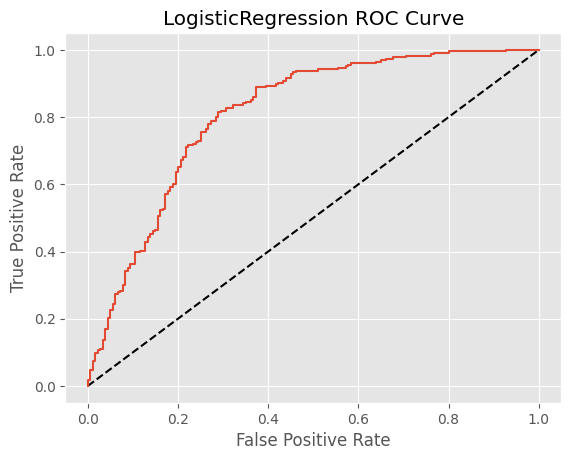

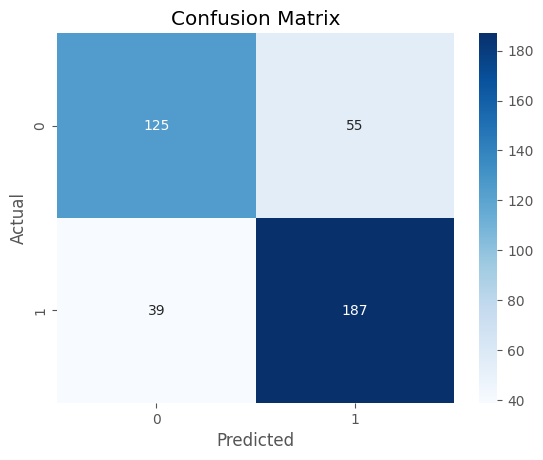

In [11]:
LR_instance = pickle.load(open('models/LogisticRegression_instance.pkl', 'rb'))

#ploting metrics
LR_instance.model_metrics()
LR_instance.roc_curve()
LR_instance.plot_confusion_matrix()


In [12]:
#model best params
LR_instance.best_params

{'logisticregression__C': 0.001,
 'logisticregression__max_iter': 10000,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'sag'}

Using these parameters to validate the model ( training and testing)

In [35]:
parameters = {'logisticregression__C': 0.001,
 'logisticregression__max_iter': 10000,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'sag'}

parameters = {'C': 0.001, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'sag'}

model_test = LogisticRegression(**parameters, random_state=42)

In [36]:
#training the model with the best parameters
model_test.fit(X_train, y_train)

LogisticRegression(C=0.001, max_iter=10000, random_state=42, solver='sag')

In [37]:
#ploting metrics
y_pred = model_test.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.1%}' )
print(f'Precision: {precision:.1%}')
print(f'Recall: {recall:.1%}')
print(f'F1: {f1:.1%}')
print(f'AUC: {auc:.1%}') #auc score


Accuracy: 72.8%
Precision: 73.2%
Recall: 79.4%
F1: 76.2%
AUC: 72.0%


Creating the best SVM model

In [13]:
instantiate_best_model(LinearSVC(random_state=42), X, y, 'roc_auc', scaler=True)

Model already saved


Accuracy: 74.9%
Precision: 78.4%
Recall: 75.7%
F1: 77.0%
AUC: 74.8%


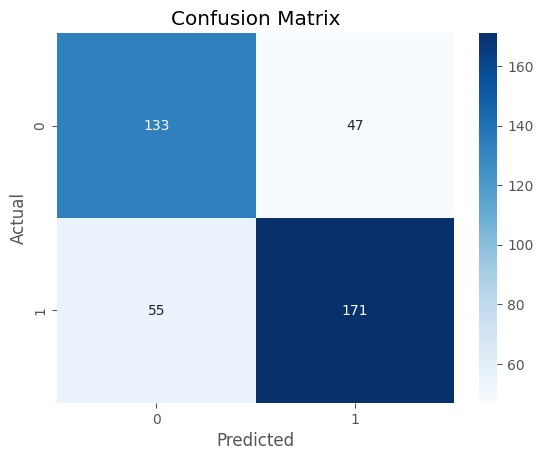

In [14]:
SVM_instance = pickle.load(open('models/LinearSVC_instance.pkl', 'rb'))
SVM_instance.model_metrics()
SVM_instance.plot_confusion_matrix()

In [15]:
#model best params
SVM_instance.best_params

{'linearsvc__C': 0.0001,
 'linearsvc__loss': 'squared_hinge',
 'linearsvc__max_iter': 100000}

Using these parameters to validate the model ( training and testing)

In [38]:
parameters = {'linearsvc__C': 0.0001,
 'linearsvc__loss': 'squared_hinge',
 'linearsvc__max_iter': 100000}

parameters = {'C': 0.0001, 'loss': 'squared_hinge', 'max_iter': 100000}

model_test = LinearSVC(**parameters, random_state=42)


In [39]:
model_test.fit(X_train, y_train)

LinearSVC(C=0.0001, max_iter=100000, random_state=42)

In [40]:
y_pred = model_test.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.1%}' )
print(f'Precision: {precision:.1%}')
print(f'Recall: {recall:.1%}')
print(f'F1: {f1:.1%}')
print(f'AUC: {auc:.1%}') #auc score


Accuracy: 73.0%
Precision: 73.4%
Recall: 79.7%
F1: 76.4%
AUC: 72.3%


Creating the best RandomForest model 


In [16]:
instantiate_best_model(RandomForestClassifier(random_state=42), X, y, 'roc_auc', scaler=True, random_search=True)

Model already saved


In [17]:
forest_instance = pickle.load(open('models/RandomForestClassifier_instance.pkl', 'rb'))
forest_instance.model_metrics()

Accuracy: 84.5%
Precision: 83.8%
Recall: 89.4%
F1: 86.5%
AUC: 83.9%


In [18]:
forest = pickle.load(open('models/RandomForestClassifier.pkl', 'rb'))
forest

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=10,
                                        max_features=None, max_leaf_nodes=30,
                                        min_samples_split=10, n_estimators=1500,
                                        random_state=42))])

Using these parameters to validate the model ( training and testing)

In [41]:
#parameters criterion='entropy', max_depth=10, max_features=None, max_leaf_nodes=30,  min_samples_split=10, n_estimators=1500, random_state=42

parameters = {'criterion': 'entropy', 'max_depth': 10, 'max_features': None,
               'max_leaf_nodes': 30, 'min_samples_split': 10, 'n_estimators': 1500, 'random_state': 42}

model_test = RandomForestClassifier(**parameters)

In [42]:
model_test.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       max_leaf_nodes=30, min_samples_split=10,
                       n_estimators=1500, random_state=42)

In [43]:
y_pred = model_test.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.1%}' )
print(f'Precision: {precision:.1%}')
print(f'Recall: {recall:.1%}')
print(f'F1: {f1:.1%}')
print(f'AUC: {auc:.1%}') #auc score


Accuracy: 72.7%
Precision: 72.6%
Recall: 80.6%
F1: 76.4%
AUC: 71.8%


To improve this model, we need to either feed more data  or/and make our model less complex. In the case of trees, the easy solution will be reduce the number of features.


Using the parematers that we found for the "prfect model", we can see that the accuracy is not impressive compared with the simpler models.

Creating the best GradientBoostingClassifier model with early stoping. If doenst improve by 0.01 acc, it stop training.

In [19]:
instantiate_best_model(GradientBoostingClassifier(random_state=42, validation_fraction=0.2,
        n_iter_no_change=5,
        tol=0.01,), X, y, 'roc_auc', scaler=True, random_search=True)

Model already saved


In [20]:
gradient_instance = pickle.load(open('models/GradientBoostingClassifier_instance.pkl', 'rb'))
gradient_instance.model_metrics()


Accuracy: 76.1%
Precision: 73.3%
Recall: 89.8%
F1: 80.7%
AUC: 74.4%


In [51]:
gradient_instance.best_params

{'gradientboostingclassifier__subsample': 0.4,
 'gradientboostingclassifier__n_estimators': 300,
 'gradientboostingclassifier__min_weight_fraction_leaf': 0.0,
 'gradientboostingclassifier__min_samples_split': 2,
 'gradientboostingclassifier__min_samples_leaf': 2,
 'gradientboostingclassifier__min_impurity_decrease': 0.3,
 'gradientboostingclassifier__max_leaf_nodes': 10,
 'gradientboostingclassifier__max_features': None,
 'gradientboostingclassifier__max_depth': 30,
 'gradientboostingclassifier__loss': 'deviance',
 'gradientboostingclassifier__learning_rate': 0.01,
 'gradientboostingclassifier__criterion': 'friedman_mse'}

In [45]:
gradient = pickle.load(open('models/GradientBoostingClassifier.pkl', 'rb'))
gradient

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=30,
                                            max_leaf_nodes=10,
                                            min_impurity_decrease=0.3,
                                            min_samples_leaf=2,
                                            n_estimators=300,
                                            n_iter_no_change=5, random_state=42,
                                            subsample=0.4, tol=0.01,
                                            validation_fraction=0.2))])

In [55]:
gradient[1].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'deviance',
 'max_depth': 30,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_impurity_decrease': 0.3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_iter_no_change': 5,
 'random_state': 42,
 'subsample': 0.4,
 'tol': 0.01,
 'validation_fraction': 0.2,
 'verbose': 0,
 'warm_start': False}

In [56]:
parameters = gradient[1].get_params()

model_test = GradientBoostingClassifier(**parameters)

In [58]:
#training the model with the best parameters
model_test.fit(X_train, y_train)


GradientBoostingClassifier(learning_rate=0.01, max_depth=30, max_leaf_nodes=10,
                           min_impurity_decrease=0.3, min_samples_leaf=2,
                           n_estimators=300, n_iter_no_change=5,
                           random_state=42, subsample=0.4, tol=0.01,
                           validation_fraction=0.2)

In [59]:
y_pred = model_test.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.1%}' )
print(f'Precision: {precision:.1%}')
print(f'Recall: {recall:.1%}')
print(f'F1: {f1:.1%}')
print(f'AUC: {auc:.1%}') #auc score

Accuracy: 73.0%
Precision: 70.5%
Recall: 87.4%
F1: 78.0%
AUC: 71.4%


Again, we confirm that we need to further tweak the features on the next notebook


### Unscaled data

Best logistic regression model

In [21]:
instantiate_best_model(LogisticRegression(random_state=42), X, y, 'roc_auc', scaler=False)

Model already saved


In [22]:
LR_instance_unscaled = pickle.load(open('models/LogisticRegression_unscaled_instance.pkl', 'rb'))
LR_instance_unscaled.model_metrics()

Accuracy: 75.4%
Precision: 76.2%
Recall: 81.0%
F1: 78.5%
AUC: 74.7%


testing model

In [60]:
LR_unscaled = pickle.load(open('models/LogisticRegression_unscaled.pkl', 'rb'))


In [66]:
# takes in the model best parameters, X_train and y_train to fit and X_test and y_test to predict

def test_model(model_instance, model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    parameters = model_instance[1].get_params()
    model_test = model(**parameters)
    model_test.fit(X_train, y_train)
    y_pred = model_test.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.1%}' )
    print(f'Precision: {precision:.1%}')
    print(f'Recall: {recall:.1%}')
    print(f'F1: {f1:.1%}')
    print(f'AUC: {auc:.1%}') #auc score
    

In [67]:
test_model(LR_unscaled, LogisticRegression)

Accuracy: 73.2%
Precision: 73.9%
Recall: 79.1%
F1: 76.4%
AUC: 72.5%


Best svm model

In [23]:
instantiate_best_model(LinearSVC(random_state=42), X, y, 'roc_auc', scaler=False)

Model already saved


In [24]:
svm_instance_unscaled = pickle.load(open('models/LinearSVC_unscaled_instance.pkl', 'rb'))
svm_instance_unscaled.model_metrics()

Accuracy: 76.4%
Precision: 77.5%
Recall: 81.0%
F1: 79.2%
AUC: 75.8%


In [68]:
svm_unscaled = pickle.load(open('models/LinearSVC_unscaled.pkl', 'rb'))

In [69]:
test_model(svm_unscaled, LinearSVC)

Accuracy: 72.7%
Precision: 73.2%
Recall: 79.2%
F1: 76.1%
AUC: 72.0%


Best random forest model

In [25]:
instantiate_best_model(RandomForestClassifier(random_state=42), X, y, 'roc_auc', scaler=False, random_search=True)

Model already saved


In [26]:
forest_instance_unscaled = pickle.load(open('models/RandomForestClassifier_unscaled_instance.pkl', 'rb'))
forest_instance_unscaled.model_metrics()

Accuracy: 100.0%
Precision: 100.0%
Recall: 100.0%
F1: 100.0%
AUC: 100.0%


In [70]:
forest_unscaled = pickle.load(open('models/RandomForestClassifier_unscaled.pkl', 'rb'))

In [71]:
test_model(forest_unscaled, RandomForestClassifier)

Accuracy: 72.9%
Precision: 72.4%
Recall: 81.8%
F1: 76.8%
AUC: 71.9%


Best GB model

In [27]:
instantiate_best_model(GradientBoostingClassifier(random_state=42,validation_fraction=0.2,
        n_iter_no_change=5,
        tol=0.001,), X, y, 'roc_auc', scaler=False, random_search=True)

Model already saved


In [28]:
gradient_instance_unscaled = pickle.load(open('models/GradientBoostingClassifier_unscaled_instance.pkl', 'rb'))
gradient_instance_unscaled.model_metrics()

Accuracy: 75.9%
Precision: 72.5%
Recall: 91.2%
F1: 80.8%
AUC: 73.9%


In [72]:
gradient_unscaled = pickle.load(open('models/GradientBoostingClassifier_unscaled.pkl', 'rb'))

In [73]:
test_model(gradient_unscaled, GradientBoostingClassifier)

Accuracy: 72.9%
Precision: 70.1%
Recall: 88.5%
F1: 78.2%
AUC: 71.2%


We can conclude that scaled data gives the best performances, and from now on, we gonna try to improve performance by either getting more data or/and decreasing the number of features , thus, models complexity.

## To finish the notebook, lets show that we can load the fitted model to visualize its attributes, for the previous fitted scaler and model.

In [29]:
model = pickle.load(open('models/LogisticRegression.pkl', 'rb'))
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=0.001, max_iter=10000, random_state=42,
                                    solver='sag'))])

In [30]:
model[-1].coef_

array([[ 3.12385005e-02,  1.03038523e-02,  2.80696989e-02,
         3.04643527e-02,  5.24554544e-03,  4.29914617e-02,
         1.83204349e-02,  6.08693253e-03,  2.35105848e-02,
         3.74259784e-03,  3.82339497e-02,  3.37086259e-02,
         2.84379301e-02,  7.81863746e-03,  8.85839368e-03,
        -1.49464179e-02, -1.19994201e-02,  4.45435394e-02,
         3.92778520e-02,  3.48508804e-02,  2.99998792e-03,
         5.12147733e-04,  4.43123075e-03,  8.87475713e-03,
         2.64847754e-02,  1.18065204e-02,  5.79644317e-03,
         1.12566485e-02, -1.56947036e-02,  0.00000000e+00,
         4.08764193e-02, -4.30425887e-02,  1.23486461e-02,
        -2.39203381e-03, -9.49937384e-03,  3.08793372e-02,
        -1.45709566e-03,  1.17275076e-02,  2.82929723e-02,
         1.97620747e-02,  2.12917474e-02, -1.23911390e-02,
         2.02021825e-02,  1.51613636e-02,  2.64363195e-02,
        -1.15607409e-04,  1.14824506e-02, -8.91890471e-03,
         8.72923397e-03,  3.23299383e-02,  6.37536994e-0

In [31]:
model[-1]

LogisticRegression(C=0.001, max_iter=10000, random_state=42, solver='sag')

In [32]:
model[0].mean_

array([ 40.88464068,  87.46908403,   0.46830842,  12.68080908,
        34.96456175,   0.36205797,  17.20720276,  22.06281862,
         0.78060516,  10.06035192,  34.34657129,  44.4069232 ,
        24.90494984,   7.43644137,   4.80965302,  12.88102286,
        19.32099984, 111.65729321,   0.5756781 ,   0.54106422,
         0.40074182,   0.25554605,  22.86830291,  77.70772899,
        50.49785397,  60.91374774,   7.59616839,   9.05652853,
        11.69162144, 100.        , 114.3128515 , 112.35545963,
        10.02269364,  19.43718138,   0.83219429,   4.18138464,
         8.97237296,   0.78006833,   6.44861043,   7.79789508,
         0.99299671,   3.70235159,   8.75094557,  11.21526065,
         7.99457326,   2.51496464,   2.08131886,   3.99580661,
         4.28523269,  27.47599079,  14.22019405,   0.96275201,
         0.96114784,   0.87780127,   1.06579395,  21.23756783,
        39.14412926,  25.92970728,  43.02066272,   5.96857425,
         9.7015458 ,  40.13533136,  35.30028778, 183.86

In [33]:
model[0].feature_names_in_

array(['home_rolling_fg', 'home_rolling_fga', 'home_rolling_fg%',
       'home_rolling_3p', 'home_rolling_3pa', 'home_rolling_3p%',
       'home_rolling_ft', 'home_rolling_fta', 'home_rolling_ft%',
       'home_rolling_orb', 'home_rolling_drb', 'home_rolling_trb',
       'home_rolling_ast', 'home_rolling_stl', 'home_rolling_blk',
       'home_rolling_tov', 'home_rolling_pf', 'home_rolling_pts',
       'home_rolling_ts%', 'home_rolling_efg%', 'home_rolling_3par',
       'home_rolling_ftr', 'home_rolling_orb%', 'home_rolling_drb%',
       'home_rolling_trb%', 'home_rolling_ast%', 'home_rolling_stl%',
       'home_rolling_blk%', 'home_rolling_tov%', 'home_rolling_usg%',
       'home_rolling_ortg', 'home_rolling_drtg', 'home_rolling_fg_max',
       'home_rolling_fga_max', 'home_rolling_fg%_max',
       'home_rolling_3p_max', 'home_rolling_3pa_max',
       'home_rolling_3p%_max', 'home_rolling_ft_max',
       'home_rolling_fta_max', 'home_rolling_ft%_max',
       'home_rolling_orb_max', 'ho